# 주성분 추출 단계
1. 데이터 표준화 전처리
2. 공분산 행렬(covariance matrix) 구성
3. 공분산 행렬의 고윳값(eignevalue)과 고유 벡터(eigenvector) 구하기
4. 고윳값을 내림차순으로 정렬하여 고유 벡터의 순위 매기기

In [1]:
import pandas as pd

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
df_wine = pd.read_csv(url, header=None)
df_wine

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [2]:
# Wine 데이터셋을 [훈련 데이터 : 테스트 데이터 = 70 : 30]으로 분할

from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values , df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3,
    stratify = y, # 매개변수를 바탕으로 계층적 샘플링
    random_state = 0) # 결과를 재현하기 위해 설정

# 이후 표준화를 적용하여 단위 분산을 갖도록
# 특성 표준화 전처리
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [9]:
print("X_train:")
print(X_train.shape)

print("\ny_train:")
print(y_train.shape)

print("\nX_test:")
print(X_test.shape)

print("\ny_test:")
print(y_test.shape)

X_train:
(124, 13)

y_train:
(124,)

X_test:
(54, 13)

y_test:
(54,)


In [3]:
import numpy as np

# 표준화 전처리된 훈련 데이터셋의 공분산 행렬 계산
cov_mat = np.cov(X_train_std.T)
# 고윳값 분해 수행
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([4.84274532, 2.41602459, 1.54845825, 0.96120438, 0.84166161,
       0.6620634 , 0.51828472, 0.34650377, 0.3131368 , 0.10754642,
       0.21357215, 0.15362835, 0.1808613 ])

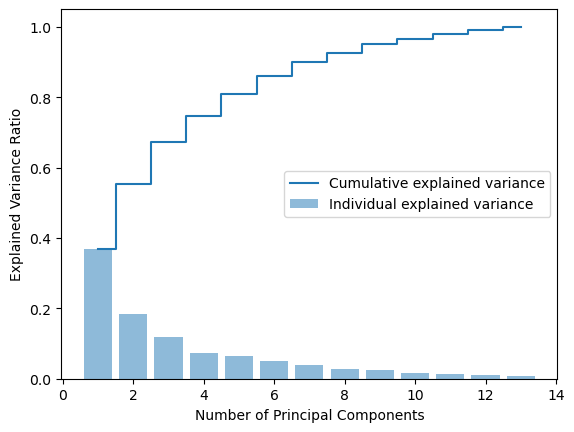

In [4]:
# 데이터셋을 새로운 특성 부분 공간으로 압축하여 줄여야 하기 때문에 가장 많은 정보(분산)를 가진 고유 벡터(주성분) 일부만 선택
# 고윳값은 고유벡터의 크기를 결정하므로 고윳값을 내림차순으로 정렬
# 설명된 분산 비율: 전체 고윳값의 합에서 고윳값의 비율

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.legend(loc='best')
plt.show()



* 첫 번째 주성분이 분산의 40%를 차지하고, 두 번째까지 합하면 전체 데이터셋에 있는 분산의 대략 60%를 설명한다.


# 특성 변환
* 고윳값이 가장 큰 k개의 벡터 선택
    * 여기서 k는 새로운 특성 부분 공간의 차원이 된다.
* 최상위 k개의 고유벡터로 투영 행렬 W를 만든다.
* 투영 행렬 W를 사용해서 d차원 입력 데이터셋 X를 새로운 k차원의 특성 부분 공간으로 변환
    * = 투영 행렬을 사용하여 데이터를 저차원 부분 공간으로 변환

In [5]:
# (고윳값, 고유 벡터) 튜플의 리스트 만들기
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# 고윳값을 기준으로 (고윳값, 고유 벡터) 튜플을 내림차순으로 정렬
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# 2차원 산점도를 그리기 위해 두 개의 고유 벡터를 선택했지만,
# 실전에서는 계산 효율성과 모델 성능 사이의 절충점을 찾아 주성분 개수를 결정해야 한다.
W = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print(W)

[[-0.13724218  0.50303478]
 [ 0.24724326  0.16487119]
 [-0.02545159  0.24456476]
 [ 0.20694508 -0.11352904]
 [-0.15436582  0.28974518]
 [-0.39376952  0.05080104]
 [-0.41735106 -0.02287338]
 [ 0.30572896  0.09048885]
 [-0.30668347  0.00835233]
 [ 0.07554066  0.54977581]
 [-0.32613263 -0.20716433]
 [-0.36861022 -0.24902536]
 [-0.29669651  0.38022942]]


In [6]:
X_train_std[0].dot(W)

array([2.38299011, 0.45458499])

In [7]:
X_train_pca = X_train_std.dot(W)

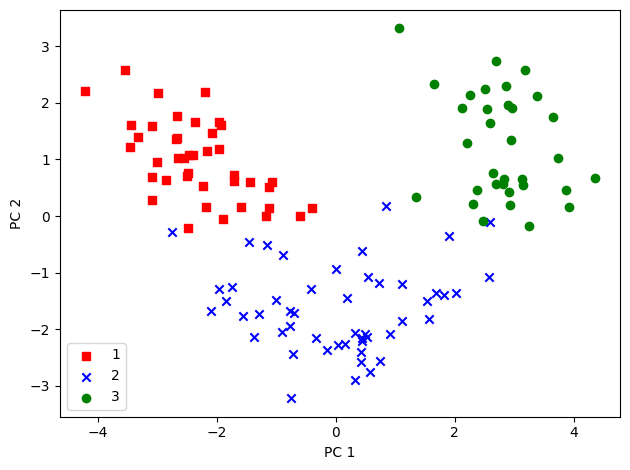

In [8]:
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, marker=m, label=l)

plt.legend()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()